In [3]:
from haystack.document_stores import FAISSDocumentStore
from haystack.utils import convert_files_to_docs, fetch_archive_from_http, clean_wiki_text
from haystack.nodes import DensePassageRetriever
from haystack.nodes import Seq2SeqGenerator
from haystack.pipelines import GenerativeQAPipeline
import os

In [4]:
if os.path.exists('fais.db'):
    faiss_ds = FAISSDocumentStore.load('fais.db')
else:
    faiss_ds = FAISSDocumentStore(embedding_dim=768, faiss_index_factory_str="Flat", index='bioasq-2ndrank')

# Example with Wiki Documents

In [3]:
# Let's first get some files that we want to use
doc_dir = "data/tutorial12"
s3_url = "https://s3.eu-central-1.amazonaws.com/deepset.ai-farm-qa/datasets/documents/wiki_gameofthrones_txt12.zip"
fetch_archive_from_http(url=s3_url, output_dir=doc_dir)

# Convert files to dicts
docs = convert_files_to_docs(dir_path=doc_dir, clean_func=clean_wiki_text, split_paragraphs=True)

# Now, let's write the dicts containing documents to our DB.
faiss_ds.write_documents(docs)

NameError: name 'faiss_ds' is not defined

In [ ]:
retriever = DensePassageRetriever(
    document_store=document_store,
    query_embedding_model="vblagoje/dpr-question_encoder-single-lfqa-wiki",
    passage_embedding_model="vblagoje/dpr-ctx_encoder-single-lfqa-wiki",
)

document_store.update_embeddings(retriever)

In [ ]:
generator = Seq2SeqGenerator(model_name_or_path="vblagoje/bart_lfqa")

In [ ]:
pipe = GenerativeQAPipeline(generator, retriever)

In [ ]:
pipe.run(
    query="How did Arya Stark's character get portrayed in a television adaptation?", params={"Retriever": {"top_k": 3}}
)

# Example with BioASQ

In [8]:
type(docs[0])

haystack.schema.Document

In [9]:
type(prediction['documents'][0])

NameError: name 'prediction' is not defined

In [10]:
document_store.delete_documents()

NameError: name 'document_store' is not defined

In [11]:
document_store.get_document_count()

NameError: name 'document_store' is not defined

In [12]:
# Write bm25 docs to our DB.
document_store.write_documents(prediction['documents'])

NameError: name 'document_store' is not defined

In [13]:
p_retrieval = DocumentSearchPipeline(retriever)
res = p_retrieval.run(query="Tell me something about Arya Stark?", params={"Retriever": {"top_k": 10}})
print_documents(res, max_text_len=512)

NameError: name 'DocumentSearchPipeline' is not defined

# Search with BM25 (100 docs)

In [5]:
%load_ext autoreload
%autoreload 2
import os
import re
import json
import copy
import sys
from tqdm import tqdm
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

import pytrec_eval
import numpy as np
import pandas as pd
from elasticsearch import Elasticsearch
from haystack.pipelines import Pipeline
from haystack.nodes import BM25Retriever, ElasticsearchRetriever
from haystack.document_stores import ElasticsearchDocumentStore
from haystack.nodes import BM25Retriever, SentenceTransformersRanker
from haystack.nodes.reader import FARMReader
from haystack.utils import print_answers
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../../')
import globals
from elastic_search_utils import elastic_utils
from haystack_utils.retrievers import BioASQ_Retriever
import bioasq_eval
import haystack_util

working_folder = globals.PATH.home + '/data/working_folder'
eval_home = globals.PATH.eval_home + '/'
gs_google_docs = eval_home + '/examples/aueb_google_docs/aueb_nlp-bioasq6b-submissions/'
index_name = globals.BIOASQ.index + 'working_folder'
model_id = 'doc_retrieval_test'

es = Elasticsearch(globals.ES.server)

# set document store
document_store = ElasticsearchDocumentStore()

Home path : /opt/bioasq/col-un-bioasq11
Eval path : /opt/bioasq/Evaluation-Measures


In [6]:
#evaluate over aueb documents
test_batch_docs = [ #('','8b5_ES_30_full.json')
                ('6B1_golden.json', gs_google_docs+'1-aueb-nlp-4.json'),
                ('6B2_golden.json', gs_google_docs+'2-aueb-nlp-4.json'),
                ('6B3_golden.json', gs_google_docs+'3-aueb-nlp-4.json'),
                ('6B4_golden.json', gs_google_docs+'4-aueb-nlp-4.json'),
                ('6B5_golden.json', gs_google_docs+'5-aueb-nlp-4.json')
               ]

In [7]:
chat_gpt_file = f'{eval_home}/golden_docs/6B1_gpt.json'
chat_gpt = json.load(open(chat_gpt_file,mode='r'))
chatgpt_questions = dict((elem['id'],elem) for elem in chat_gpt['questions'])

In [30]:
scores = []
def search_bm25_faiss(q, bm25_retriever, faiss_ds, faiss_retriever, sample_id=None):
    docs_bm25 = bm25_retriever.retrieve(q, top_k = 50)
    chat_gpt_q = q
    if sample_id:
        chat_gpt_q = chatgpt_questions[sample_id]['short']
    faiss_ds.delete_documents()
    faiss_ds.write_documents(docs_bm25)
    faiss_ds.update_embeddings(faiss_retriever)
    print(q)
    print(chat_gpt_q)
    faiss_docs = faiss_retriever.retrieve(query=q, top_k = 5)
    for d in docs_bm25:
        scores.append(d.score)
    final_docs = docs_bm25[0:5] + faiss_docs
    return final_docs

In [21]:
docs_test = bm25_retriever.retrieve('what are the symptoms of covid', top_k = 10)

In [22]:
from haystack.nodes import BM25Retriever, ElasticsearchRetriever, EmbeddingRetriever

In [27]:
# create the retriever
bm25_retriever = BioASQ_Retriever(document_store = document_store)
faiss_retriever = EmbeddingRetriever(
    document_store = faiss_ds,
    embedding_model="sentence-transformers/multi-qa-mpnet-base-dot-v1",
)
# 768 - sentence-transformers/msmarco-distilbert-base-dot-prod-v3
# 328 - multi-qa-MiniLM-L6-cos-v1
# 768 - multi-qa-distilbert-cos-v1
# 768 - msmarco-distilbert-base-dot-prod-v3

#faiss_retriever = EmbeddingRetriever(
#    document_store = faiss_ds,
#    embedding_model = 'distilroberta-base-msmarco-v2', 
#    model_format = 'sentence_transformers'
#)
#search_bm25_faiss('covid',bm25_retriever,faiss_ds,faiss_retriever)

In [28]:
docs = search_bm25_faiss('what are the symtoms of covid',bm25_retriever,faiss_ds,faiss_retriever)

Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

what are the symtoms of covid
what are the symtoms of covid


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

TypeError: unhashable type: 'Document'

In [ ]:
docs[0].score

In [ ]:
search_bm25_faiss('what are the principal symtomps of covid',bm25_retriever,faiss_ds,faiss_retriever)

In [ ]:
# search_bm25_faiss('what are the principal symtomps of covid',bm25_retriever,faiss_ds,faiss_retriever)

In [31]:
df = pd.DataFrame( columns=('batch', 'Mean precision', 'Recall', 'F-Measure', 'MAP', 'GMAP') )

for i, batch_file in enumerate(test_batch_docs):
    test_batch_json = json.load(open(batch_file[1]))
    for sample in tqdm(test_batch_json['questions'], position=0):
        prediction = search_bm25_faiss(sample['body'],bm25_retriever,faiss_ds,faiss_retriever,sample_id=sample['id'])
        doc_list = [ globals.BIOASQ.doc_relative_url + doc.id for doc in prediction]
        sample['documents'] = doc_list[0:10]
        print(len(doc_list))
            
    submission = test_batch_json.copy()
    submission_file_name =  working_folder + "/" + model_id + '_'+batch_file[1].split('/')[-1]
    json.dump(submission, open(submission_file_name, 'w'))
    docs_score, pass_score = bioasq_eval.get_scores_phaseA(batch_file[0], submission, path_home=eval_home)
    print('Document Scores',docs_score)
    print('Passage Scores',pass_score)
    df.loc[i] = [ batch_file[0].split('.')[0] + '_' + batch_file[1].split('/')[-1].split('.')[0] ] + pass_score
    break 
df.to_csv(working_folder + "/" + model_id+'.csv', index=False)

  0%|                                                                                                                   | 0/100 [00:00<?, ?it/s]

Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Does echinacea increase anaphylaxis risk?
No, there is no evidence that echinacea increases anaphylaxis risk. Studies have found that echinacea is generally safe and does not increase the risk of anaphylaxis.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|█                                                                                                          | 1/100 [00:04<07:37,  4.62s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Do cephalopods use RNA editing less frequently than other species?
No, cephalopods use RNA editing just as frequently as other species. They have been found to use RNA editing to modify proteins and regulate gene expression.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|██▏                                                                                                        | 2/100 [00:09<08:02,  4.93s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which algorithm is available for computing minimal absent words using external memory?
The External Memory Minimal Absent Words (EMMAW) algorithm is available for computing minimal absent words using external memory. It uses a two-level indexing structure to efficiently store and retrieve minimal absent words from external memory.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  3%|███▏                                                                                                       | 3/100 [00:14<07:54,  4.89s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Is there an RNAi drug being developed to treat amyloidosis?
Yes, there is an RNAi drug being developed to treat amyloidosis. It is called ALN-AGT and is designed to reduce the production of the protein that causes amyloidosis.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  4%|████▎                                                                                                      | 4/100 [00:19<07:52,  4.92s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which main ribotype of Clostridium difficile is responsible of the recent outbreak?
The main ribotype responsible for the recent outbreak is ribotype 027, which is a hypervirulent strain of C. difficile.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  5%|█████▎                                                                                                     | 5/100 [00:24<07:44,  4.88s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Is there an association between carcinoid syndrome and mitral valve disease?
No, there is no known association between carcinoid syndrome and mitral valve disease.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|██████▍                                                                                                    | 6/100 [00:29<07:33,  4.83s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Do origins of replication close to yeast centromeres fire early or late?
Origins of replication close to yeast centromeres tend to fire late in the S-phase of the cell cycle.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|███████▍                                                                                                   | 7/100 [00:33<07:29,  4.84s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Is there any role of 5hmC in T-cell development and differentiation?
Yes, 5hmC plays a role in T-cell development and differentiation. It is involved in the regulation of gene expression, epigenetic reprogramming, and the control of lineage commitment.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|████████▌                                                                                                  | 8/100 [00:40<08:03,  5.26s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Are there RNAi approaches considered for the treatment of kidney injury?
Yes, RNAi approaches are being considered for the treatment of kidney injury. These approaches involve using small interfering RNAs to target and silence specific genes that are involved in the development of kidney injury.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  9%|█████████▋                                                                                                 | 9/100 [00:45<08:01,  5.29s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which is the transcriptome of RNA polymerase III?
The transcriptome of RNA polymerase III is composed of small nuclear RNAs (snRNAs) and transfer RNAs (tRNAs) which are involved in the regulation of gene expression and protein synthesis.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|██████████▌                                                                                               | 10/100 [00:50<07:41,  5.12s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Is propranolol used for treatment of infantile hemangioma?
Yes, propranolol is used for treatment of infantile hemangioma. It is a beta-blocker that helps reduce the size of the hemangioma and prevent complications.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 11%|███████████▋                                                                                              | 11/100 [00:54<07:21,  4.96s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

What is the genetic basis of the Delayed Sleep-Phase Syndrome (DSPS)?
DSPS is caused by a mutation in the gene hPer2, which affects the body's circadian rhythm, leading to a delay in the onset of sleep.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 12%|████████████▋                                                                                             | 12/100 [00:59<07:04,  4.83s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which factors drive replisome disassembly during DNA replication termination and mitosis?
Replisome disassembly is driven by the binding of termination proteins to the DNA, which triggers the release of the replisome components and the separation of the two daughter strands.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 13%|█████████████▊                                                                                            | 13/100 [01:03<06:42,  4.63s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Can the CEP290 gene mutations be targeted by AAV-mediated gene therapy?
Yes, AAV-mediated gene therapy has been used to target CEP290 gene mutations. It involves delivering a healthy copy of the gene to the cells to replace the mutated gene.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 14%|██████████████▊                                                                                           | 14/100 [01:08<06:50,  4.77s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

What is a coligo?
Coligo is a cloud-based platform that enables users to create, manage, and share interactive 3D product experiences. It helps businesses create immersive 3D product experiences to engage customers and drive sales.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|███████████████▉                                                                                          | 15/100 [01:12<06:21,  4.48s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which type of urinary incontinence is diagnosed with the Q tip test?
The Q tip test is used to diagnose stress incontinence, which is the involuntary leakage of urine during physical activity or when coughing or sneezing.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 16%|████████████████▉                                                                                         | 16/100 [01:17<06:30,  4.65s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

How many genes constitute the DosR regulon, controlled by the dormancy survival regulator (DosR) in Mycobacterium tuberculosis?
The DosR regulon in Mycobacterium tuberculosis consists of over 200 genes, which are involved in various processes such as dormancy, stress response, and metabolism.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|██████████████████                                                                                        | 17/100 [01:22<06:36,  4.78s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

List the partners of budding yeast Cdc48 that are important for disassembly of ubiquitylated CMG helicase at the end of chromosome replication
The partners of budding yeast Cdc48 important for disassembly of ubiquitylated CMG helicase at the end of chromosome replication are Ufd1-Npl4, Rad23, and Dsk2.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|███████████████████                                                                                       | 18/100 [01:27<06:32,  4.78s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

What are jakinibs?
Jakinibs are traditional Indian garments worn by women. They are usually made of cotton or silk and feature intricate embroidery and embellishments. They are worn as a symbol of modesty and grace.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 19%|████████████████████▏                                                                                     | 19/100 [01:32<06:24,  4.75s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Are mutations in the nf1 gene associated with memory?
Yes, mutations in the NF1 gene have been associated with memory deficits, including impaired working memory, verbal memory, and executive functioning.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|█████████████████████▏                                                                                    | 20/100 [01:37<06:41,  5.02s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Is tretinoin effective for photoaging?
Yes, tretinoin is effective for photoaging. It helps reduce wrinkles, age spots, and other signs of aging caused by sun exposure.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 21%|██████████████████████▎                                                                                   | 21/100 [01:41<06:19,  4.81s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

What is the function of the dormancy survival regulator (DosR) in Mycobacterium tuberculosis?
DosR is a transcription factor that helps Mycobacterium tuberculosis survive in a dormant state by regulating the expression of genes involved in dormancy, stress response, and metabolism.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|███████████████████████▎                                                                                  | 22/100 [01:47<06:25,  4.94s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Are there ultraconserved genomic regions in the budding yeast?
Yes, there are ultraconserved genomic regions in the budding yeast. These regions are highly conserved across species and are thought to be important for maintaining essential cellular functions.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|████████████████████████▍                                                                                 | 23/100 [01:51<06:15,  4.88s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which Janus kinase does decernotinib target?
Decernotinib targets Janus Kinase 2 (JAK2). It is an oral medication used to treat myelofibrosis, a type of bone marrow cancer.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|█████████████████████████▍                                                                                | 24/100 [01:56<06:09,  4.86s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Is autophagy modulated in a circadian fashion?
Yes, autophagy is modulated in a circadian fashion. Autophagy is regulated by the circadian clock, and its levels vary throughout the day in response to the changing metabolic needs of the body.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██████████████████████████▌                                                                               | 25/100 [02:01<05:58,  4.78s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which tendons are affected in the Dequervain's tenosynovitis?
Dequervain's tenosynovitis affects the tendons of the thumb, specifically the abductor pollicis longus and extensor pollicis brevis tendons.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|███████████████████████████▌                                                                              | 26/100 [02:05<05:42,  4.63s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Are TAD boundaries in Drosophila depleted in highly-expressed genes?
Yes, TAD boundaries in Drosophila are depleted in highly-expressed genes, suggesting that gene expression levels may be involved in the formation of TADs.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 27%|████████████████████████████▌                                                                             | 27/100 [02:10<05:40,  4.66s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Does TUC.338 inhibit colorectal cancer?
No, TUC.338 does not inhibit colorectal cancer. However, it has been shown to reduce the growth of colorectal cancer cells in laboratory studies.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 28%|█████████████████████████████▋                                                                            | 28/100 [02:15<05:44,  4.79s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

What is oclacitinib?
Oclacitinib is a prescription medication used to treat itching and inflammation caused by allergies in dogs. It works by blocking the action of certain chemicals in the body that cause itching and inflammation.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|██████████████████████████████▋                                                                           | 29/100 [02:20<05:44,  4.86s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

List the four most important interferonopathies
1. Aicardi-Goutières Syndrome: A rare genetic disorder characterized by inflammation of the brain and other organs.
2. Mevalonate Kinase Deficiency: A rare metabolic disorder caused by a deficiency of


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 30%|███████████████████████████████▊                                                                          | 30/100 [02:24<05:19,  4.57s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

What is the purpose of the FRAX scale?
The FRAX scale is a tool used to assess an individual's risk of developing osteoporotic fractures. It uses clinical risk factors to calculate a 10-year probability of fracture.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 31%|████████████████████████████████▊                                                                         | 31/100 [02:28<05:03,  4.40s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

How are topologically associating domains (TAD) associated with replication timing?
TADs are associated with replication timing as they are thought to be the structural units of the genome that control when and where replication occurs. They are thought to act as boundaries that regulate the timing of replication.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 32%|█████████████████████████████████▉                                                                        | 32/100 [02:32<04:53,  4.31s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which R/Bioconductor package has been developed for the analysis of psychiatric disease genes?
The Psychiatric Disease Genes package (PDG) has been developed for the analysis of psychiatric disease genes. It provides a comprehensive set of tools for analyzing gene expression data from psychiatric diseases, including gene set enrichment analysis, gene-gene interaction


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|██████████████████████████████████▉                                                                       | 33/100 [02:37<05:00,  4.49s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Has ruxolitinib received FDA approval?
Yes, ruxolitinib has received FDA approval for the treatment of myelofibrosis and polycythemia vera, two rare blood disorders.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 34%|████████████████████████████████████                                                                      | 34/100 [02:42<04:59,  4.54s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

What is the function of the gene MDA5?
MDA5 is a gene that encodes a protein that helps to detect and respond to viral infections. It is part of the innate immune system and helps to activate the production of antiviral molecules.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|█████████████████████████████████████                                                                     | 35/100 [02:47<05:06,  4.72s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Is scuba diving safe during pregnancy?
No, scuba diving is not safe during pregnancy. The pressure changes and physical exertion can be dangerous for both mother and baby.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|██████████████████████████████████████▏                                                                   | 36/100 [02:51<04:53,  4.59s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which individuals show preferential colonization of the Prevotellaceae bacteria in their guts?
Individuals with a diet high in animal proteins and low in plant-based fibers show preferential colonization of Prevotellaceae bacteria in their guts.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 37%|███████████████████████████████████████▏                                                                  | 37/100 [02:56<05:00,  4.78s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

What is the main focus of the CVE R/Bioconductor package?
The CVE R/Bioconductor package is focused on providing tools for the analysis of gene expression data, including differential expression, clustering, and gene set enrichment.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|████████████████████████████████████████▎                                                                 | 38/100 [03:00<04:46,  4.62s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Does deflazacort have more side effects than prednisone?
No, deflazacort and prednisone have similar side effects, such as weight gain, increased appetite, and mood changes.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 39%|█████████████████████████████████████████▎                                                                | 39/100 [03:06<04:50,  4.76s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which is the conserved motif of DEAD box proteins?
The conserved motif of DEAD box proteins is the DEAD box motif, which is a conserved sequence of amino acids that is essential for the ATP-dependent RNA helicase activity of these proteins.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████▍                                                               | 40/100 [03:10<04:43,  4.73s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which drug can be reversed with idarucizumab?
Idarucizumab is a drug used to reverse the anticoagulant effects of dabigatran, a medication used to prevent blood clots.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 41%|███████████████████████████████████████████▍                                                              | 41/100 [03:15<04:43,  4.81s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

What is the genetic basis of Ohdo syndrome?
Ohdo syndrome is caused by a mutation in the gene CEP135, which is involved in the formation of centrioles and cilia. This mutation leads to abnormal development of the brain, heart, and other organs.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|████████████████████████████████████████████▌                                                             | 42/100 [03:20<04:31,  4.68s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

What is the function of the TMEM132 genes?
TMEM132 genes are involved in the regulation of neuronal excitability and synaptic plasticity. They are thought to play a role in learning and memory formation.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████▌                                                            | 43/100 [03:23<04:12,  4.43s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

What is the relationship of fyn kinase and tau?
Fyn kinase is a protein kinase that phosphorylates tau, a protein involved in the regulation of microtubule assembly and stability. This phosphorylation is thought to be involved in the development of tau-related


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|██████████████████████████████████████████████▋                                                           | 44/100 [03:29<04:18,  4.62s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Are neurexins localized at pre-synapses?
Yes, neurexins are localized at pre-synapses and are involved in the formation and maintenance of synapses. They act as receptors for neurotransmitters and other molecules, and are essential for proper synaptic function.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|███████████████████████████████████████████████▋                                                          | 45/100 [03:34<04:22,  4.77s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which two cotransporters are inhibited by sotagliflozin?
Sotagliflozin inhibits sodium-glucose cotransporter 1 (SGLT1) and sodium-glucose cotransporter 2 (SGLT2). These cotransporters are responsible


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|████████████████████████████████████████████████▊                                                         | 46/100 [03:39<04:24,  4.89s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which are the main manifestations of Ohdo syndrome?
Ohdo syndrome is a rare genetic disorder characterized by intellectual disability, seizures, and physical abnormalities such as short stature, low muscle tone, and facial dysmorphism.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|█████████████████████████████████████████████████▊                                                        | 47/100 [03:43<04:12,  4.76s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Describe GARLIC (GWAS-based Prediction Toolkit for Connecting Diseases and Cell Types)
GARLIC is a toolkit that uses GWAS data to predict the connection between diseases and cell types. It helps to identify potential therapeutic targets and biomarkers for diseases.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 48%|██████████████████████████████████████████████████▉                                                       | 48/100 [03:48<04:11,  4.83s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

What does davunetide do to microtubules?
Davunetide stabilizes microtubules, preventing them from breaking down and promoting their assembly. This helps to maintain the structure and function of cells.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|███████████████████████████████████████████████████▉                                                      | 49/100 [03:52<03:52,  4.57s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Has Cas9 gene editing the potential to correct inhereted hearing loss?
Yes, Cas9 gene editing has the potential to correct inherited hearing loss. It can be used to target and modify specific genes that are associated with hearing loss.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████                                                     | 50/100 [03:57<03:47,  4.55s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Describe mechanism of action of Napabucasin.
Napabucasin is a cancer drug that works by blocking the signal pathways that promote tumor growth and spread. It works by inhibiting the activity of STAT3, a protein involved in cell growth and survival, thus preventing tumor growth and spread


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|██████████████████████████████████████████████████████                                                    | 51/100 [04:02<03:46,  4.63s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which algorithm is used by the UCSC Genome Browser?
The UCSC Genome Browser uses the BLAT (BLAST-Like Alignment Tool) algorithm to quickly search and align DNA and protein sequences. It is a fast and efficient algorithm for finding regions of similarity between biological sequences.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 52%|███████████████████████████████████████████████████████                                                   | 52/100 [04:06<03:40,  4.59s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Does DDX54 play a role in DNA damage response?
Yes, DDX54 plays a role in DNA damage response by regulating the expression of genes involved in DNA repair and cell cycle control.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 53%|████████████████████████████████████████████████████████▏                                                 | 53/100 [04:11<03:45,  4.80s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Is davunetide being considered for the treatment of progressive supranuclear palsy?
Yes, davunetide is being considered for the treatment of progressive supranuclear palsy. Clinical trials are underway to assess its safety and efficacy.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████████████████████████████████████████████████████████▏                                                | 54/100 [04:16<03:43,  4.86s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which aminoacid position in the human CREB protein is phosphorylated?
Serine 133 is the aminoacid position in the human CREB protein that is phosphorylated. This phosphorylation is important for CREB's transcriptional activity.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 55%|██████████████████████████████████████████████████████████▎                                               | 55/100 [04:21<03:41,  4.93s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which drugs were tested in the KEYNOTE-006 study?
The KEYNOTE-006 study tested the efficacy of pembrolizumab (Keytruda) in combination with chemotherapy for the treatment of advanced non-small cell lung cancer.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 56%|███████████████████████████████████████████████████████████▎                                              | 56/100 [04:27<03:41,  5.04s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which proteins are controlling sterol metabolism in S. cerevisiae?
The proteins controlling sterol metabolism in S. cerevisiae are ScHMG1, ScERG3, ScERG5, ScERG6, and ScERG24. These proteins are involved in the synthesis, degradation, and transport of


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 57%|████████████████████████████████████████████████████████████▍                                             | 57/100 [04:32<03:37,  5.06s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Is Drk essential for anesthesia-resistant memory (ARM) in Drosophila?
No, Drk is not essential for ARM in Drosophila. Studies have shown that ARM can be induced in Drk mutants, indicating that Drk is not necessary for ARM formation.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████████████████████████████████████████████████████████████▍                                            | 58/100 [04:37<03:28,  4.95s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Is ACI-35 a passive vaccine?
No, ACI-35 is not a passive vaccine. It is an active vaccine, which uses a weakened form of the virus to stimulate the body's immune system to create antibodies.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 59%|██████████████████████████████████████████████████████████████▌                                           | 59/100 [04:41<03:23,  4.95s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which are the effects of ALDH2 deficiency?
ALDH2 deficiency can cause facial flushing, nausea, headaches, and increased risk of esophageal cancer, stroke, and heart disease.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|███████████████████████████████████████████████████████████████▌                                          | 60/100 [04:46<03:18,  4.97s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

What is mechanism of action of galunisertib?
Galunisertib is a small molecule inhibitor of the TGF-β receptor type I, which blocks the activation of downstream signaling pathways involved in tumor growth and progression.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 61%|████████████████████████████████████████████████████████████████▋                                         | 61/100 [04:52<03:17,  5.06s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which gene is the paralog of yeast UPC2?
The paralog of yeast UPC2 is UPC1. UPC1 and UPC2 are two closely related genes that encode ubiquitin carboxyl-terminal hydrolases, which are involved in the degradation of ubiqu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|█████████████████████████████████████████████████████████████████▋                                        | 62/100 [04:57<03:11,  5.05s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

What is the FIRE (Functional Inference of Regulators of Expression) tool?
FIRE is a tool used to infer regulatory relationships between transcription factors and genes based on gene expression data. It uses a Bayesian network to identify potential regulatory relationships.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 63%|██████████████████████████████████████████████████████████████████▊                                       | 63/100 [05:02<03:08,  5.08s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

What is the administration route of IVIG in Alzheimer's disease patients?
IVIG is typically administered intravenously, usually over a period of several hours. It is used to treat Alzheimer's disease by reducing inflammation and improving cognitive function.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|███████████████████████████████████████████████████████████████████▊                                      | 64/100 [05:07<03:06,  5.18s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Where is the enzyme PM20D1 localized?
PM20D1 is a mitochondrial enzyme localized in the inner membrane of the mitochondria. It is involved in the metabolism of fatty acids and is essential for normal mitochondrial function.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|████████████████████████████████████████████████████████████████████▉                                     | 65/100 [05:12<02:54,  4.97s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Is dasatinib effective for treatment of glioblastoma?
Yes, dasatinib has been found to be effective in treating glioblastoma, with some studies showing improved survival rates and decreased tumor growth.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 66%|█████████████████████████████████████████████████████████████████████▉                                    | 66/100 [05:17<02:48,  4.94s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

What is the role of the positive effector of transcription (pet) in the hepatitis B virus?
The positive effector of transcription (PET) is a protein that binds to the viral genome and activates the transcription of the viral genes, allowing the virus to replicate and spread.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|███████████████████████████████████████████████████████████████████████                                   | 67/100 [05:22<02:42,  4.91s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Is there increased recombination rate in human regulatory domains?
Yes, increased recombination rate has been observed in human regulatory domains. This is due to the presence of multiple recombination hotspots, which are regions of the genome that are prone to recombination.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 68%|████████████████████████████████████████████████████████████████████████                                  | 68/100 [05:27<02:42,  5.07s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Has IVIG been tested in clinical trials for the treatment of Alzheimer's disease?
Yes, IVIG has been tested in clinical trials for the treatment of Alzheimer's disease. Results have been inconclusive, with some studies showing potential benefits and others showing no effect.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|█████████████████████████████████████████████████████████████████████████▏                                | 69/100 [05:33<02:41,  5.22s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Is NEMO a zinc finger protein?
No, NEMO is not a zinc finger protein. NEMO stands for NF-κB Essential Modulator and is a protein that is involved in the activation of the NF-κB transcription factor.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|██████████████████████████████████████████████████████████████████████████▏                               | 70/100 [05:37<02:32,  5.09s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Is enzastaurin effective treatment of glioblastoma?
Enzastaurin has not been proven to be an effective treatment for glioblastoma. Clinical trials have not shown any significant improvement in survival or quality of life for patients with glioblastoma.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████████████████████████████████████████████████████████████████████████▎                              | 71/100 [05:43<02:29,  5.17s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which enzymes are responsible for base J creation in Trypanosoma brucei?
The enzymes responsible for base J creation in Trypanosoma brucei are the DNA methyltransferases DNMT1 and DNMT2. These enzymes catalyze the transfer of a methyl group to the base J, resulting in its formation


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|████████████████████████████████████████████████████████████████████████████▎                             | 72/100 [05:48<02:22,  5.07s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

What is the role of Kmt5a in liver?
Kmt5a is a lysine methyltransferase that plays a role in regulating gene expression in the liver. It is involved in the epigenetic control of gene expression, which helps to maintain normal liver function.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▍                            | 73/100 [05:52<02:10,  4.84s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

How does increased GDF15 affect body weight?
Increased GDF15 levels have been linked to reduced body weight, likely due to its role in regulating energy balance and metabolism.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▍                           | 74/100 [05:57<02:09,  4.97s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

What is inhibited by a drug rilotumumab?
Rilotumumab is a drug that inhibits the growth of certain types of cancer cells by blocking a protein called HER2.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▌                          | 75/100 [06:02<02:02,  4.89s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

How many PML isoforms exist in the human genome?
There are at least 8 known PML isoforms in the human genome, which are generated by alternative splicing of the PML gene.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 76%|████████████████████████████████████████████████████████████████████████████████▌                         | 76/100 [06:07<01:57,  4.88s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

What is metaSPAdes?
metaSPAdes is a de novo genome assembler for metagenomic data. It is designed to assemble genomes from large collections of short-read sequencing data, such as those generated by Illumina sequencing platforms.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▌                        | 77/100 [06:10<01:44,  4.55s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which receptor does GDF15 bind?
GDF15 binds to the GFRAL receptor. GFRAL is a receptor found on the surface of cells that binds GDF15 and helps regulate cell growth and survival.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████▋                       | 78/100 [06:15<01:40,  4.57s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

List the two most important hematological features of the Evans syndrome
1. Co-occurrence of autoimmune hemolytic anemia (AIHA) and immune thrombocytopenia (ITP): Evans Syndrome is characterized by the simultaneous presence of both AIHA and ITP.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████▋                      | 79/100 [06:19<01:34,  4.52s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

How many of the human PML isoforms are cytosolic?
Six of the human PML isoforms are cytosolic. These include PML I, II, III, IV, V, and VI.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████▊                     | 80/100 [06:24<01:32,  4.64s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

How many Groucho-related genes (GRG) are contained in the mouse genome?
There are currently no known Groucho-related genes (GRG) in the mouse genome. However, research is ongoing to identify potential GRG in the mouse genome.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████▊                    | 81/100 [06:30<01:33,  4.90s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Does a tonsillectomy affect the patient's voice?
Yes, a tonsillectomy can affect a patient's voice. The surgery can cause swelling and inflammation in the throat, which can lead to hoarseness and a change in the patient's voice.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████▉                   | 82/100 [06:34<01:26,  4.79s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

What is the difference between ganglion mother cells (GMC) and intermediate neural precursor cells (INP) in Drosophila?
GMCs are the primary neural progenitor cells in Drosophila, while INPs are derived from GMCs and are more specialized, giving rise to neurons and glia.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▉                  | 83/100 [06:40<01:24,  4.98s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

What is the function of the TFIIS transcriptional factor (Dst1) in yeast?
TFIIS (Dst1) is a transcriptional factor in yeast that helps to promote transcription elongation by stabilizing paused RNA polymerase II complexes and increasing the processivity of the enzyme.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████                 | 84/100 [06:44<01:17,  4.82s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Does TFIIS affect nucleosome positioning?
Yes, TFIIS can affect nucleosome positioning by increasing the rate of transcription elongation, which can lead to changes in the positioning of nucleosomes.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████                | 85/100 [06:49<01:11,  4.75s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

How does Dst1 knock-out affect transcription in yeast?
Dst1 knock-out in yeast results in increased transcription of genes involved in stress response, cell cycle, and metabolism. It also affects the expression of genes involved in chromatin remodeling and transcriptional regulation.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▏              | 86/100 [06:54<01:07,  4.82s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which method for subsampling of NGS reads requires only gene counts?
Subsampling of NGS reads using the gene-count based method requires only gene counts and does not require sequence information. It involves randomly selecting a subset of reads from the original dataset and then counting the number of reads that map to each


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████▏             | 87/100 [06:59<01:03,  4.86s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which test is used to diagnose colour synesthesia?
The Stroop Test is used to diagnose colour synesthesia. It involves naming the colour of words printed in different colours, and is used to measure the interference of colour associations with the words.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▎            | 88/100 [07:03<00:55,  4.66s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

What is measured through the NOMe-Seq methodology?
NOMe-Seq is a method used to measure the levels of DNA methylation in a genome. It uses bisulfite sequencing to identify and quantify the amount of methylation at specific sites in the genome.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▎           | 89/100 [07:08<00:51,  4.70s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Is DNA methylation correlated with nucleosome occupancy?
Yes, DNA methylation is correlated with nucleosome occupancy. Studies have shown that DNA methylation can affect nucleosome positioning and occupancy, leading to changes in gene expression.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▍          | 90/100 [07:12<00:46,  4.63s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which are the properties of mammalian GA-sequences?
Mammalian GA-sequences are short, conserved, non-coding sequences found in the genome of mammals. They are involved in gene regulation and are often located near the promoter region of genes.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▍         | 91/100 [07:17<00:42,  4.73s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

How may CTCF mediate splicing?
CTCF can bind to DNA and recruit splicing factors, which can influence the splicing of pre-mRNA into mature mRNA.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▌        | 92/100 [07:22<00:37,  4.70s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which are the best methods for the prediction of circular RNA (circRNA)?
The best methods for the prediction of circRNA include de novo assembly, splice junction detection, and comparative genomics. Additionally, machine learning algorithms such as deep learning and support vector machines can be used to improve accuracy.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▌       | 93/100 [07:27<00:33,  4.75s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Does RNA polymerase II have RNA cleavage activity?
No, RNA polymerase II does not have RNA cleavage activity. It is an enzyme that catalyzes the transcription of DNA into mRNA.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▋      | 94/100 [07:32<00:28,  4.77s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which RNA polymerase II subunit carries RNA cleavage activity?
The RNA polymerase II subunit carrying RNA cleavage activity is the C-terminal domain (CTD). It is responsible for recognizing and cleaving the RNA transcript at the 3' end.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 95/100 [07:36<00:23,  4.78s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Is there a sequence bias in MNase digestion patterns?
Yes, there is a sequence bias in MNase digestion patterns. MNase preferentially digests regions of DNA with high A/T content, resulting in a bias towards shorter fragments in these regions.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 96/100 [07:41<00:19,  4.78s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which topoisomerase is essential in yeast?
Essential topoisomerase in yeast is Topoisomerase II, which is responsible for relieving torsional strain in DNA during replication, transcription, and recombination.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 97/100 [07:46<00:14,  4.70s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Which yeast nucleosomes are preferentially marked by H2A.Z?
H2A.Z is preferentially marked on nucleosomes in yeast that contain the transcription factor Abf1, which is involved in regulating gene expression.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 98/100 [07:50<00:09,  4.73s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

What is the origin of XUT transcripts in yeast?
XUT transcripts in yeast originate from the XUT1 gene, which encodes a protein involved in the metabolism of xylose, a sugar found in plant cell walls.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 99/100 [07:54<00:04,  4.51s/it]

10


Writing Documents:   0%|          | 0/50 [00:00<?, ?it/s]

Updating Embedding:   0%|          | 0/50 [00:00<?, ? docs/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

How are cryptic unstable transcripts (CUTs) defined?
Cryptic unstable transcripts (CUTs) are short, non-coding transcripts that are expressed at low levels and are rapidly degraded. They are often associated with gene regulation and can be used to identify novel regulatory elements.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:59<00:00,  4.80s/it]

10


Document Scores [0.20846031746031746, 0.4180233238983239, 0.2265871345089968, 0.10313888888888881, 0.015123116694872646]
Passage Scores [0.21269651172236054, 0.25011684801025924, 0.19239072397187112, 0.16589622913215266, 0.011068641301611446]


In [19]:
submission

{'questions': [{'id': '5a67a049b750ff4455000007',
   'body': 'Does echinacea increase anaphylaxis risk?',
   'documents': ['http://www.ncbi.nlm.nih.gov/pubmed/9507713',
    'http://www.ncbi.nlm.nih.gov/pubmed/18831749',
    'http://www.ncbi.nlm.nih.gov/pubmed/11814277',
    'http://www.ncbi.nlm.nih.gov/pubmed/9640313',
    'http://www.ncbi.nlm.nih.gov/pubmed/27757381',
    'http://www.ncbi.nlm.nih.gov/pubmed/17085774',
    'http://www.ncbi.nlm.nih.gov/pubmed/23113455',
    'http://www.ncbi.nlm.nih.gov/pubmed/28731887',
    'http://www.ncbi.nlm.nih.gov/pubmed/31126553',
    'http://www.ncbi.nlm.nih.gov/pubmed/35441718'],
   'snippets': [{'document': 'http://www.ncbi.nlm.nih.gov/pubmed/18831749',
     'text': 'CONCLUSION In otitis-prone young children, treating colds with this form of echinacea does not decrease the risk of acute otitis media, and may in fact increase risk.',
     'offsetInBeginSection': 1624,
     'offsetInEndSection': 1790,
     'beginSection': 'abstract',
     'endSec

<Axes: ylabel='Density'>

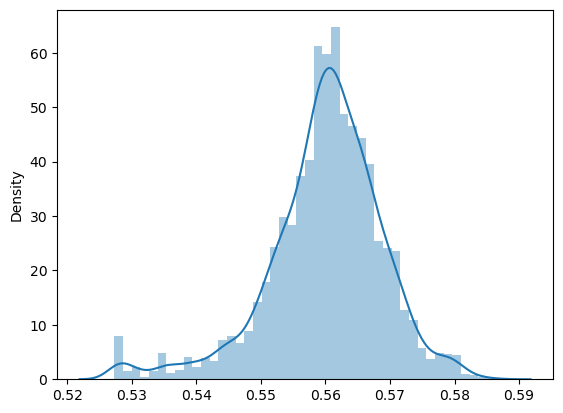

In [95]:
import seaborn as sns

sns.distplot(scores)

In [ ]:
# create the retriever
bm25_retriever = BioASQ_Retriever(document_store = document_store)
# create the Query Pipeline
pipeline = Pipeline()
pipeline.add_node(component=retriever, name="Retriever", inputs=["Query"])
prediction = pipeline.run(query="covid", params={"Retriever": {"top_k": 100}})
# predict
print([p.id for p in prediction['documents']])

In [60]:
q = 'what is covid'
docs = bm25_retriever.retrieve(q, top_k = 100)

In [61]:
len(docs)

100

In [62]:
faiss_ds.delete_documents()
faiss_ds.write_documents(docs)

Writing Documents:   0%|          | 0/100 [00:00<?, ?it/s]

In [68]:
faiss_retriever2 = DensePassageRetriever(
    document_store=faiss_ds,
    query_embedding_model="vblagoje/dpr-question_encoder-single-lfqa-wiki",
    passage_embedding_model="vblagoje/dpr-ctx_encoder-single-lfqa-wiki",
)

faiss_ds.update_embeddings(faiss_retriever2)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizerFast'.


Updating Embedding:   0%|          | 0/100 [00:00<?, ? docs/s]

Create embeddings:   0%|          | 0/112 [00:00<?, ? Docs/s]

In [69]:
faiss_ds.update_embeddings(faiss_retriever)

Updating Embedding:   0%|          | 0/100 [00:00<?, ? docs/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

RuntimeError: Embedding dimensions of the model (768) don't match the embedding dimensions of the document store (128). Initiate FAISSDocumentStore again with arg embedding_dim=768.

In [65]:
faiss_ds.get_document_count()

100

In [66]:
faiss_retriever.retrieve(query=q)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

AssertionError: 